# 深度自编码器


本教程将仔细研究自动编码器 (AE)。自动编码器经过训练，将图像等输入数据编码为较小的特征向量，然后通过第二个神经网络（称为解码器）重建它。因为将输入数据压缩为更少量的特征，特征向量被称为网络的**瓶颈**。
此属性在许多应用程序中都很有用，特别是在压缩数据或根据超出像素级比较的指标来比较图像时。
除了了解自动编码器框架之外， 还将看到**反卷积**（或转置卷积）运算符用于放大特征图的高度和宽度。
这种技术在很多场景都是必须的，例如，从一个小的特征向量输入获取一个全尺寸图像的输出（例如在 VAE、GAN 或超分辨率应用中）。

首先导入一些库。

In [3]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    %pip install --quiet pytorch-lightning>=2.0
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
torch.set_float32_matmul_precision('high')
# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_393864/3402415430.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cuda:0


  有 4 个预训练模型需要下载。请注意调整变量“DATASET_PATH”和“CHECKPOINT_PATH”。

In [4]:
import urllib.request
from urllib.error import HTTPError
#pathname = "/home/xmpan/teaching/modern_ML_course/saved_models-main/S2/GAN_VAE_NF/AE"
#base_url = "file://127.0.0.1"+urllib.request.pathname2url(pathname)

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/home/huilin/project/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/home/huilin/project/VAE-MNIST"
#AE_CIFAR0/"

# Files to download
pretrained_files = ["cifar10_64.ckpt", "cifar10_128.ckpt", "cifar10_256.ckpt", "cifar10_384.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.

本教程使用 CIFAR10 数据集。在 CIFAR10 中，每个图像都有 3 个颜色通道，大小为 32x32 像素。由于自动编码器不受图像概率建模的限制，因此AE可以比 VAE 更轻松地处理更复杂的图像数据，即，3颜色通道而不是仅处理黑白通道。


与之前关于 CIFAR10 的教程（例如CNN 分类）相比， 这里没有显式归一化，让数据平均值为 0，标准差为 1，
但粗略地缩放图片各个通道的像素值，让它们的值在 -1 和 1 之间。
这样做的好处是限制像素值的取值范围将使预测/重建图像的任务变得更容易。

In [5]:
# Transformations applied on each image => only make them a tensor
#AE_CIFAR0/"
transform = transforms.Compose([
    transforms.Pad(2), # Make images 32x32 to 28x28
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)
print("Size of an example image before padding:", test_set[0][0].size())

Seed set to 42


Size of an example image before padding: torch.Size([1, 32, 32])


## 构建自动编码器 

一般来说，自动编码器由一个将输入 $x$ 映射到较低维特征向量 $z$ 的 **编码器** 和一个由$z$重构 输入​​ $\hat{x}$ 的 **解码器** 组成。
通过比较 $x$ 和 $\hat{x}$ 并优化参数来增加 $x$ 和 $\hat{x}$ 之间的相似度来训练模型。下面的自动编码器框架的插图给出了上述流程。

<center width="100%"><img src="autoencoder_visualization.svg" style="display: block; margin-left: auto; margin-right: auto;" width="650px"/></center>

  首先从实现编码器开始。编码器实际上由一个深度卷积网络组成，使用跨步(特殊步长的)卷积逐层缩小图像。
  将图像缩小三倍后，展平特征并应用线性层。
  因此，潜在表示 $z$ 是一个大小为 *d* 的向量，可以灵活选择。

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

请注意，此处不应用批量归一化，原因在于这里希望每个图像的编码独立于所有其他图像。
应用批量归一化可能会在编码或解码中引入所不希望的相关性。
在某些实现中，大家仍然可以看到使用批量归一化，因为它也可以用作正则化的一种形式。
尽管如此，更好的做法是在必要时使用其他标准化技术，例如实例标准化或层标准化。
鉴于模型规模较小，这里可以忽略归一化。

解码器是编码器的镜像、逆转版本。
唯一的区别是用转置卷积（即反卷积）代替跨步卷积来提升特征张量的维度。
转置卷积可以想象为将步幅添加到输入而不是输出，因此可以提升维度。
有关内核大小为 3、步幅为 2、填充为 1 的“nn.ConvTranspose2d”层的说明，请参见下文（图来源 - [Vincent Dumoulin 和 Francesco Visin](https://arxiv.org/abs/1603.07285) :

<center width="100%"><img src="deconvolution.gif" width="250px"></center>

可以看到，对于大小为 $3\times3$ 的输入，获得 $5\times5$ 的输出。
然而，为了真正进行卷积的反向操作，需要确保该层将输入形状缩放2倍（例如$4\times4\to8\times8$）。
为此，可以指定参数“output_padding”，它将附加值添加到输出形状中。
请注意，这里不是执行零填充，而是增加计算的输出形状。

总的来说，解码器可以实现如下：

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

这里选择的编码器和解码器网络相对简单。通常，大家会使用包括基于 ResNet 的架构这样的更复杂的网络。
这样的复杂网络，读者可参阅 [VQ-VAE](https://arxiv.org/abs/1711.00937) 和 [NVAE](https://arxiv.org/abs/2007.03898)，这些文献虽然讨论的是 VAE 的架构，但相关讨论同样适用于标准自动编码器。

最后，将编码器和解码器一起添加到自动编码器架构中。将自动编码器定义为 PyTorch Lightning 模块，以简化所需的训练代码：

In [8]:
class Autoencoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 1, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=20, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)                             
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

对于损失函数，这里使用均方误差（MSE）。均方误差促使网络特别关注与实际值偏差较大的那些像素值。
重建时预测 127 而不是 128 并不重要，但将 0 与 128 混淆就更会导致网络性能大幅度下降。
请注意，与 VAE 相比，这里不预测每个像素值的概率，而是使用距离度量。
这节省了大量参数并简化了训练。
为了获得对每个像素生成的更直观的直觉判断，这里输出在批量维度上平均的平方误差总和。

然而，MSE 也有一些相当大的缺点。
通常，MSE 会导致图像模糊。
由于小噪声/高频模式会导致非常低的误差，它们会在重建过程移除。
为了确保重建真实的图像，可以将生成对抗网络与自动编码器结合起来，就像在下面提到的文献所做的那样。
例如，[此处](https://arxiv.org/abs/1704.02304)、[此处](https ://arxiv.org/abs/1511.05644)或这些[幻灯片](http://elarosca.net/slides/iccv_autoencoder_gans.pdf)。
此外，使用 MSE 比较两个图像并不一定反映它们的视觉相似性。
例如，假设自动编码器重建了向右和底部移动一个像素的图像。尽管图像几乎相同，但与只重建了图像一半像素的输出相比，网络依然会给出更大的损失值（参见下面的代码）。
解决该问题的一个方案是使用单独的、预先训练的 CNN，并使用较低层中视觉特征的距离作为距离度量，而不是直接在像素级上比较。

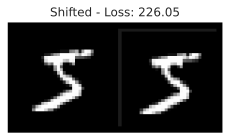

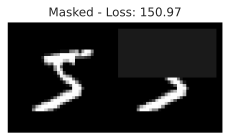

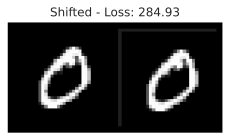

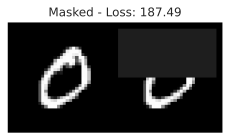

In [9]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

### 训练模型 

训练过程希望通过查看模型的重建来跟踪学习进度。为此，  在 PyTorch Lightning 中实现一个回调对象，它将每 $N$ 次遍历所得的重建添加到的tensorboard：

In [10]:
import matplotlib.pyplot as plt
import torchvision

class GenerateCallback(pl.Callback):
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()

            # Plot images locally using matplotlib
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.imshow(np_grid)
            plt.axis('off')
            plt.show()
            # 获取并打印训练和验证的损失
            train_loss = trainer.logged_metrics.get('train_loss')
            val_loss = trainer.logged_metrics.get('val_loss')
            if train_loss is not None and val_loss is not None:
                print(f'Epoch {trainer.current_epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')


  现在将编写一个训练函数，允许  训练具有不同隐维度的自动编码器，并返回测试和验证分数。

In [11]:
def train_mnist(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"mnist_{latent_dim}"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         #accelerator="cpu",  # 强制使用 CPU
                         devices=1,
                         max_epochs=50, 
                         enable_progress_bar=False,  # 禁用内置进度条
                             callbacks=[
                             ModelCheckpoint(
                                save_weights_only=True,
                                monitor="val_loss",  # 确保您的训练逻辑中有定义和记录 val_loss
                                mode="min",  # 保存最小验证损失的模型
                                filename="{epoch}-{val_loss:.2f}"  # 定义文件名格式
                                            ),
                                GenerateCallback(get_train_images(8), every_n_epochs=10),
                                LearningRateMonitor("epoch")
                                       ]
                         )
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim, num_input_channels=1, width=32, height=32)
    trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

### 比较隐维度 
当训练自动编码器时，需要为隐表达 $z$ 选择一个维度。
隐维度越高，理论上看，重建效果就越好。
然而，自动编码器的目标是**压缩**数据。
因此，这里也希望保持低维度。
为了找到最佳权衡，可以训练具有不同隐维度的多个模型。
根据原始输入具有的维度 $32\times 32\times 3 = 3072$，隐维度的合理选择可能在 64 到 384 之间：


In [12]:
import os
import torch
CHECKPOINT_PATH = "/home/huilin/project/FASHIONVAEMODEL/"
latent_dim = 32
pretrained_filename = os.path.join(CHECKPOINT_PATH, f"mnist_{latent_dim}.ckpt")
if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
else:
        print("No pretrained model found, training...")
        string = "123"
#       torch.save(string, pretrained_filename)
        # 执行训练


No pretrained model found, training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/huilin/project/FASHIONVAEMODEL/mnist_4/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 106 K  | [2, 1, 32, 32] | [2, 4]        
1 | decoder | Decoder | 106 K  | [2, 4]         | [2, 1, 32, 32]
----------------------------------------------------------------------
212 K     Trainable params
0         Non-trainable params
212 K     Total params
0.852     Total estimated model params size (MB)
/home/huilin/anaconda3/envs/ML/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Tri

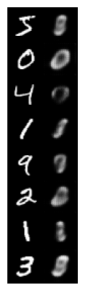

Epoch 0: train_loss=152.4739, val_loss=151.5222


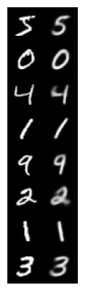

Epoch 10: train_loss=78.1440, val_loss=83.8193


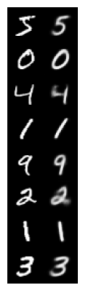

Epoch 20: train_loss=80.3806, val_loss=78.6077


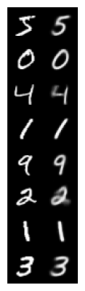

Epoch 30: train_loss=65.8741, val_loss=76.2281


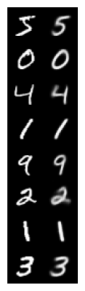

Epoch 40: train_loss=70.1075, val_loss=74.4940


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/huilin/project/FASHIONVAEMODEL/mnist_8/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 110 K  | [2, 1, 32, 32] | [2, 8]        
1 | decoder | Decoder | 111 K  | [2, 8]         | [2, 1, 32, 32]
----------------------------------------------------------------------
221 K     Trainable params
0         Non-trainable params
221 K     Total params
0.885     Total estimated model params size (MB)


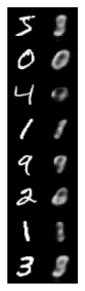

Epoch 0: train_loss=147.5107, val_loss=147.4524


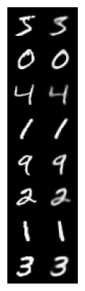

Epoch 10: train_loss=45.3662, val_loss=48.2983


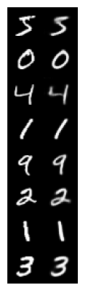

Epoch 20: train_loss=40.4948, val_loss=42.3299


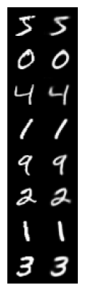

Epoch 30: train_loss=37.0515, val_loss=39.6538


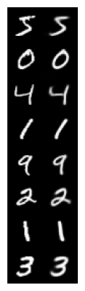

Epoch 40: train_loss=35.2243, val_loss=38.3793


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 118 K  | [2, 1, 32, 32] | [2, 16]       
1 | decoder | Decoder | 119 K  | [2, 16]        | [2, 1, 32, 32]
----------------------------------------------------------------------
237 K     Trainable params
0         Non-trainable params
237 K     Total params
0.950     Total estimated model params size (MB)


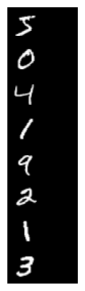

Epoch 0: train_loss=345.9750, val_loss=350.8425


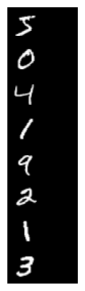

Epoch 10: train_loss=371.4859, val_loss=350.8425


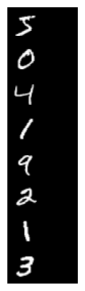

Epoch 20: train_loss=359.2085, val_loss=350.8425


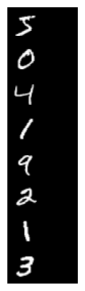

Epoch 30: train_loss=342.5155, val_loss=350.8425


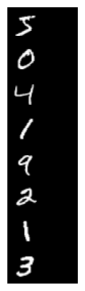

Epoch 40: train_loss=349.1200, val_loss=350.8425


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 134 K  | [2, 1, 32, 32] | [2, 32]       
1 | decoder | Decoder | 135 K  | [2, 32]        | [2, 1, 32, 32]
----------------------------------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.081     Total estimated model params size (MB)


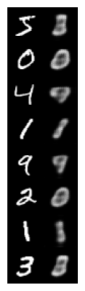

Epoch 0: train_loss=153.4143, val_loss=157.4461


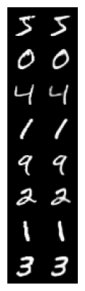

Epoch 10: train_loss=14.0279, val_loss=14.6493


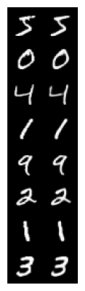

Epoch 20: train_loss=10.0523, val_loss=10.7357


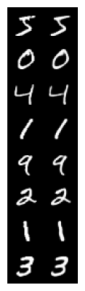

Epoch 30: train_loss=9.8235, val_loss=10.3304


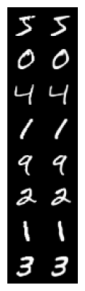

Epoch 40: train_loss=8.3152, val_loss=8.7629


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [13]:
import os
model_dict = {}
for latent_dim in [4, 8, 16, 32]:
    CHECKPOINT_PATH = "/home/huilin/project/FASHIONVAEMODEL/"
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"mnist_{latent_dim}.ckpt")
    model_ld, result_ld = train_mnist(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

# 失败
事实上这个模型失败了，根据已经训练的结果，callback的输出全部是黑色，这说明模型没有学到任何东西。
# 又成功
经过调整，将latent_dim调整为很小的数值，现在成功了
# 启发思想
在训练FashionMNIST的时候成功了，于是尝试修改latent_dim，成功，但这里比较明显，latent_dim不能太大，否则会失败

In [ ]:
import os
model_dict = {}
for latent_dim in [4, 8, 16, 32]:
    CHECKPOINT_PATH = "/home/huilin/project/FASHIONVAEMODEL/"
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"mnist_{latent_dim}.ckpt")
    model_ld, result_ld = train_mnist(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

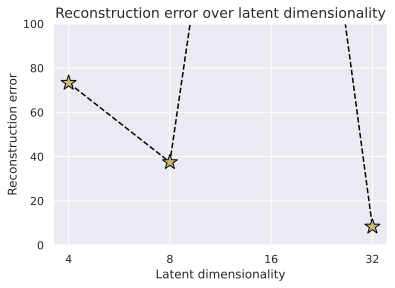

In [14]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

但是这里又一个神秘的高峰，原因不得而知

In [15]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [1]:
import os
model_dict = {}
for latent_dim in [4, 8, 16, 32]:
    CHECKPOINT_PATH = "/home/huilin/project/VAEMODEL/"
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"mnist_{latent_dim}.ckpt")
    model_ld, result_ld = Autoencoder.load_from_checkpoint(pretrained_filename)
    
    model_dict[latent_dim] = {"model": model_ld}

NameError: name 'Autoencoder' is not defined

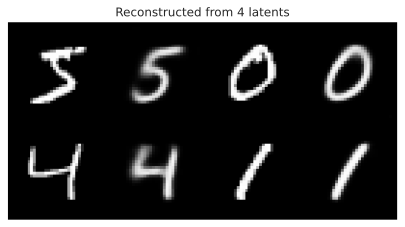

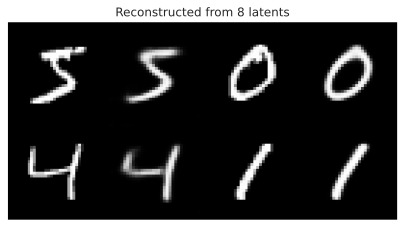

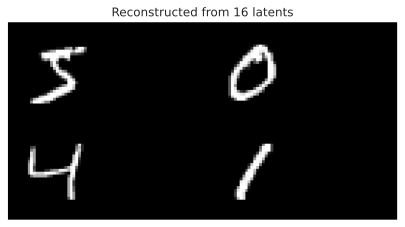

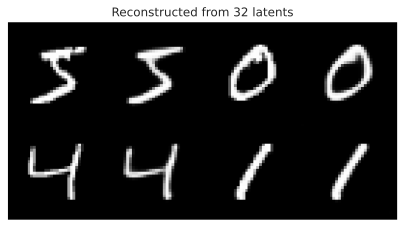

In [16]:
input_imgs = get_train_images(64)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)